In [1]:
import pandas as pd
from utils import database as db

In [2]:
players = pd.read_csv("data/0-1-IneriaRanks.csv")
players=players.set_index(players.columns[0])
pairs = pd.read_csv("data/0-1-PlayerPairs.csv")
pairs.head()

,Unnamed: 0,player1,player2
0,0,Carlos Alcaraz,Nicolas Jarry
1,1,Alexander Zverev,Matteo Berrettini
2,2,Frances Tiafoe,Grigor Dimitrov
3,3,Alejandro Davidovich Fokina,Holger Rune
4,4,Daniil Medvedev,Marton Fucsovics


In [3]:
_dictionary = pd.read_csv("data_dictionary.csv")
_data = pd.read_csv("Wimbledon_featured_matches.csv")

In [4]:
dictionary = _dictionary.copy()
data = _data.copy()
data.head()

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_won,p1_break_pt_missed,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:00,1,1,1,0,0,0,...,0,0,0,6.000,7.840,2,95.0,BC,NCTL,ND
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:38,1,1,2,0,0,0,...,0,0,0,5.253,7.094,1,118.0,B,CTL,ND
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:01,1,1,3,0,0,0,...,0,0,0,13.800,19.808,4,120.0,B,NCTL,D
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:31,1,1,4,0,0,0,...,0,0,0,51.108,75.631,13,130.0,BW,CTL,D
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:21,1,1,5,0,0,0,...,0,0,0,0.649,0.813,1,112.0,W,NCTL,NaN


# Data Pre-processing for Training

## Label Encoding for the scores

$$
{\cal F}:  \{0,15,30,40,AD\}\mapsto \{0,1,2,3,4\}
$$

In [5]:
print(data.columns)
data["p1_score"].drop_duplicates()

Index(['match_id', 'player1', 'player2', 'elapsed_time', 'set_no', 'game_no',
       'point_no', 'p1_sets', 'p2_sets', 'p1_games', 'p2_games', 'p1_score',
       'p2_score', 'server', 'serve_no', 'point_victor', 'p1_points_won',
       'p2_points_won', 'game_victor', 'set_victor', 'p1_ace', 'p2_ace',
       'p1_winner', 'p2_winner', 'winner_shot_type', 'p1_double_fault',
       'p2_double_fault', 'p1_unf_err', 'p2_unf_err', 'p1_net_pt', 'p2_net_pt',
       'p1_net_pt_won', 'p2_net_pt_won', 'p1_break_pt', 'p2_break_pt',
       'p1_break_pt_won', 'p2_break_pt_won', 'p1_break_pt_missed',
       'p2_break_pt_missed', 'p1_distance_run', 'p2_distance_run',
       'rally_count', 'speed_mph', 'serve_width', 'serve_depth',
       'return_depth'],
      dtype='object')


0        0
2       15
4       30
5       40
7       AD
143      1
144      2
147      3
148      4
151      5
152      6
966      7
967      8
1503     9
Name: p1_score, dtype: object

In [6]:
maps = {
    "0":0,
    "15":1,
    "30":2,
    "40":3,
    "AD":4,

    "0":0,
    "1":1,
    "2":2,
    "3":3,
    "4":4,
    "5":5,
    "6":6,
    "7":7,
    "8":8,
    "9":9,

    0:0,
    1:1,
    2:2,
    3:3,
    4:4,
    5:5,
    6:6,
    7:7,
    8:8,
    9:9
}

In [7]:
data["p1_score"] = data["p1_score"].map(maps)
data["p2_score"] = data["p2_score"].map(maps)
data["p1_score"].drop_duplicates()

0       0
2       1
4       2
5       3
7       4
151     5
152     6
966     7
967     8
1503    9
Name: p1_score, dtype: int64

## Score Difference

In [8]:
data["p1_score_diff"] = data["p1_score"] - data["p2_score"]
data["p2_score_diff"] = data["p2_score"] - data["p1_score"]

## Normalization for running distance, rally count & speed

$$
{\cal F}:  \Bbb R^+\mapsto \Bbb R^+
$$

$$
\Bbb E[{\cal F}]\approx 0,~\Bbb V[{\cal F}]\approx 1
$$

In [9]:
data_norm = data.copy()

### distribution of running distance

In [10]:
running_dist = data["p1_distance_run"]._append(data["p2_distance_run"])
#running_dist = running_dist[running_dist>2]
running_dist

0        6.000
1        5.253
2       13.800
3       51.108
4        0.649
         ...  
7279    50.971
7280    27.766
7281    18.328
7282    10.537
7283    25.367
Length: 14568, dtype: float64

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from utils import visualize as vs
sns.set_style("darkgrid")

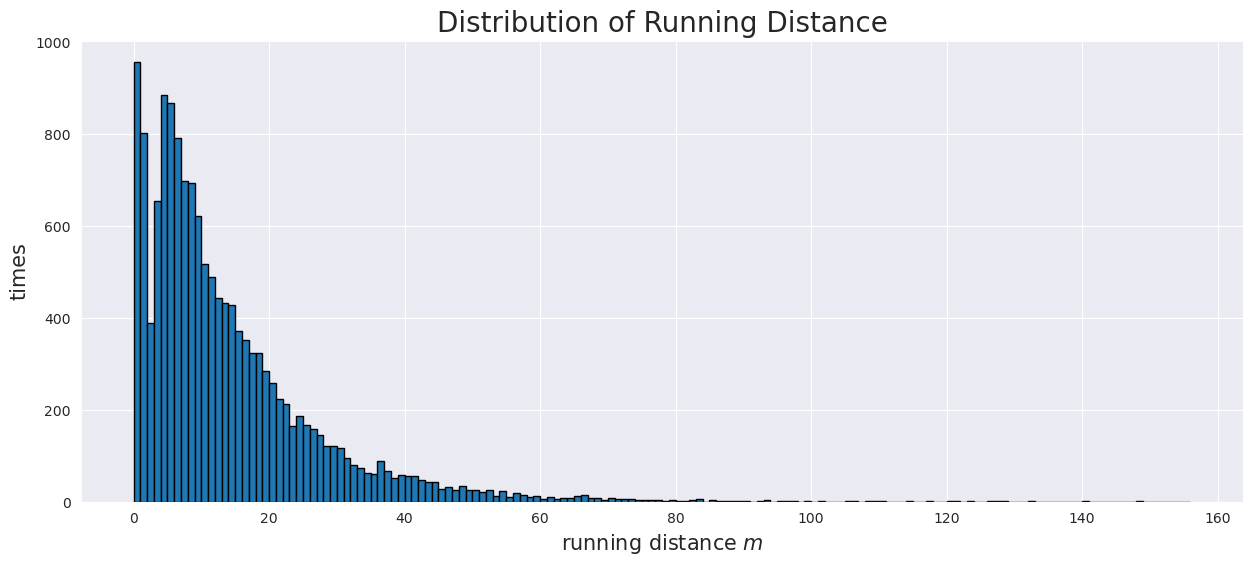

In [12]:
plt.figure(figsize=(15, 6))
plt.hist(running_dist, bins=range(int(running_dist.min()), int(running_dist.max()) + 1), edgecolor='black')

vs.set_label("Distribution of Running Distance", r"running distance $m$", "times")

vs.save("3-1-DistribOfRunningDist")
plt.show()

In [13]:
from scipy.stats import gamma
from scipy.stats import expon
import numpy as np

In [14]:
std = np.std(running_dist)

fit_params = gamma.fit(running_dist)
fit_params

(1.1512694169681708, -0.01393912167011625, 12.116759998946346)

In [15]:
x = np.linspace(0, 150, 600)
xs = np.linspace(0, 150/std, 600)
p = gamma.pdf(x, *fit_params)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


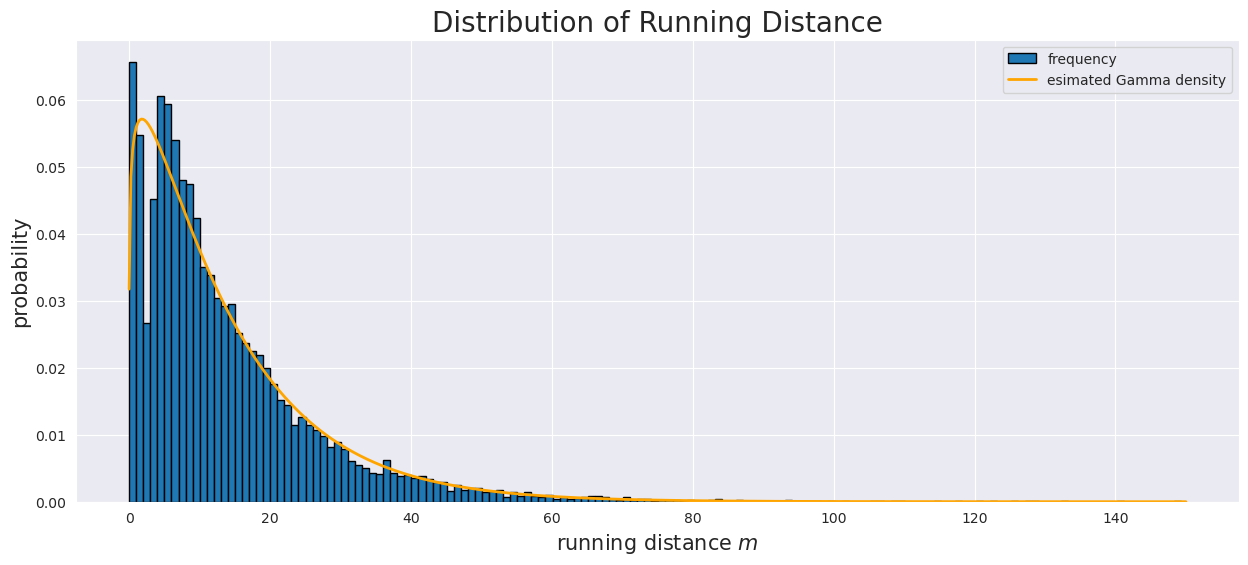

In [16]:
plt.figure(figsize=(15, 6))

plt.hist(running_dist, bins=x[::4], density=True, edgecolor='black', label = "frequency")
plt.plot(x, p, 'orange', linewidth=2, label = "esimated Gamma density")
#plt.plot(x, p, 'k', linewidth=2, label = "esimated Gamma")
plt.legend()

vs.set_label("Distribution of Running Distance", r"running distance $m$", "probability")

vs.save("3-1-DistribOfRunningDist")
plt.show()

$$
p(x,\alpha,\beta)={\beta^{-\alpha}\over \Gamma(\alpha)}x^{\alpha-1}e^{-x/\beta}
$$

$$
\alpha=1.1555147307135378,~\beta=12.129877151688223,~\sigma = \sqrt{\alpha}\beta=13.038995805596418
$$

In [17]:
a, _, b = fit_params
#nor = np.sqrt(a)*b
nor = 2*a*b

In [18]:
np.mean(running_dist/nor)

0.49950248338300485

In [19]:
data_norm["p1_distance_run"] = data["p1_distance_run"]/nor
data_norm["p2_distance_run"] = data["p2_distance_run"]/nor

### distribution of rally count

In [20]:
rc = data["rally_count"]

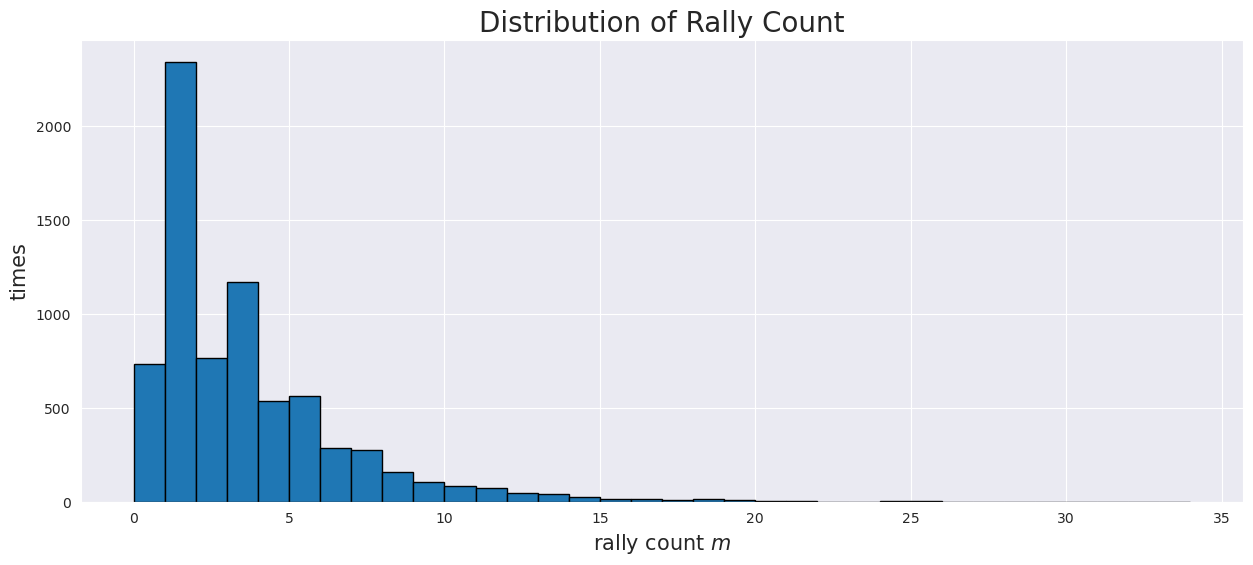

In [21]:
plt.figure(figsize=(15, 6))
plt.hist(rc, bins=range(int(rc.min()), int(rc.max()) + 1), edgecolor='black')

vs.set_label("Distribution of Rally Count", r"rally count $m$", "times")

vs.save("3-1-DistribOfRallyCount")
plt.show()

In [22]:
fit_params = gamma.fit(rc)
fit_params

x = np.linspace(0.4, 35, 600)
p = gamma.pdf(x, *fit_params)
fit_params

(0.8857051454816715, -3.0171772197565623e-22, 2.794643555513843)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


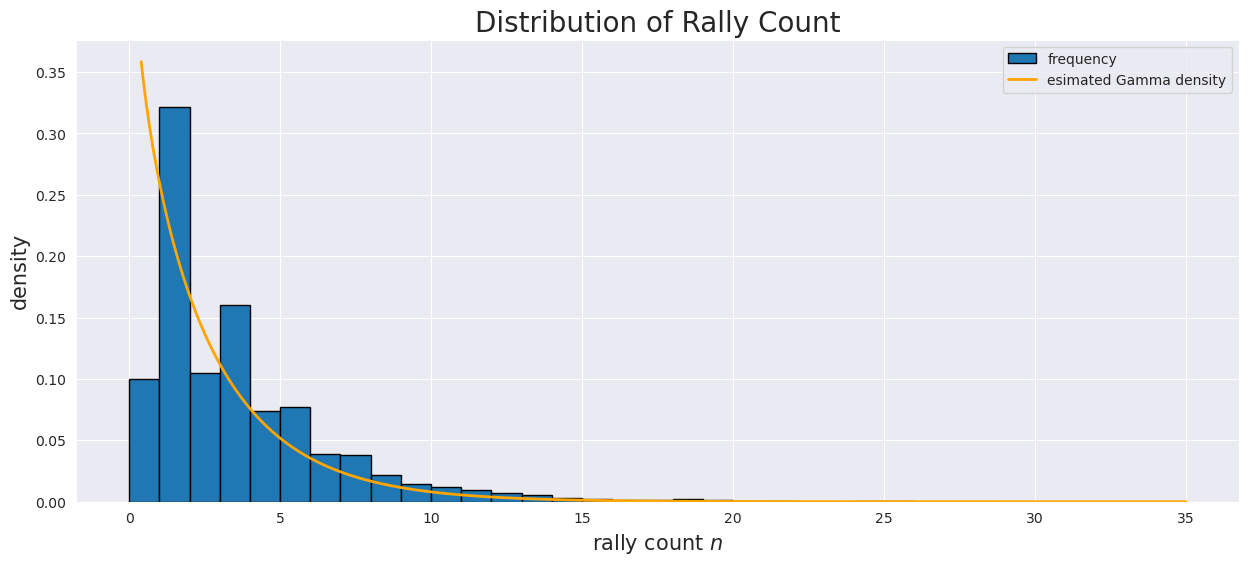

In [23]:
plt.figure(figsize=(15, 6))

plt.hist(rc, bins=range(0,35), density=True, edgecolor='black', label = "frequency")
plt.plot(x, p, 'orange', linewidth=2, label = "esimated Gamma density")
#plt.plot(x, p, 'k', linewidth=2, label = "esimated Gamma")
plt.legend()

vs.set_label("Distribution of Rally Count", r"rally count $n$", "density")

vs.save("3-1-DistribOfRallyCount")
plt.show()

In [24]:
a, _, b = fit_params
#nor = np.sqrt(a)*b
nor = 2*a*b

In [25]:
data_norm["rally_count"] = data["rally_count"]/nor
data_norm["rally_count"].head()

0    0.404003
1    0.202001
2    0.808006
3    2.626018
4    0.202001
Name: rally_count, dtype: float64

### distribution of speed

In [26]:
sp = data["speed_mph"]

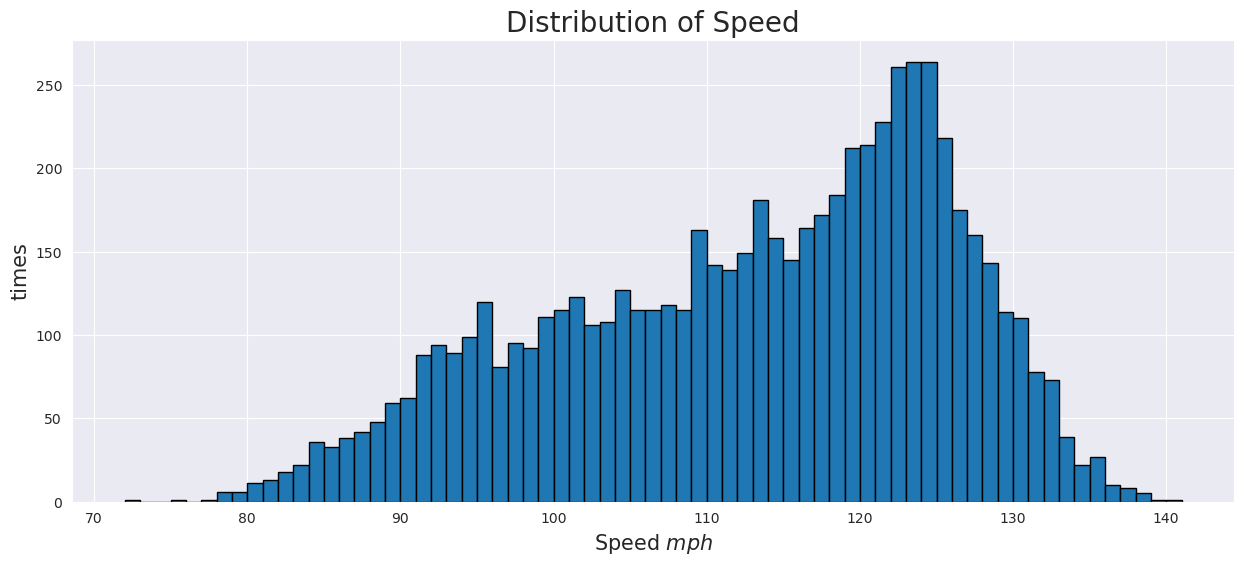

In [27]:
plt.figure(figsize=(15, 6))
plt.hist(sp, bins=range(int(sp.min()), int(sp.max()) + 1), edgecolor='black')

vs.set_label("Distribution of Speed", r"Speed $mph$", "times")

vs.save("3-1-Speed")
plt.show()

In [28]:
from scipy.stats import norm

fit_params = norm.fit(sp.dropna())
fit_params

x = np.linspace(70, 150, 600)
p = norm.pdf(x, *fit_params)
fit_params

(112.40967544396815, 12.857131644583063)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


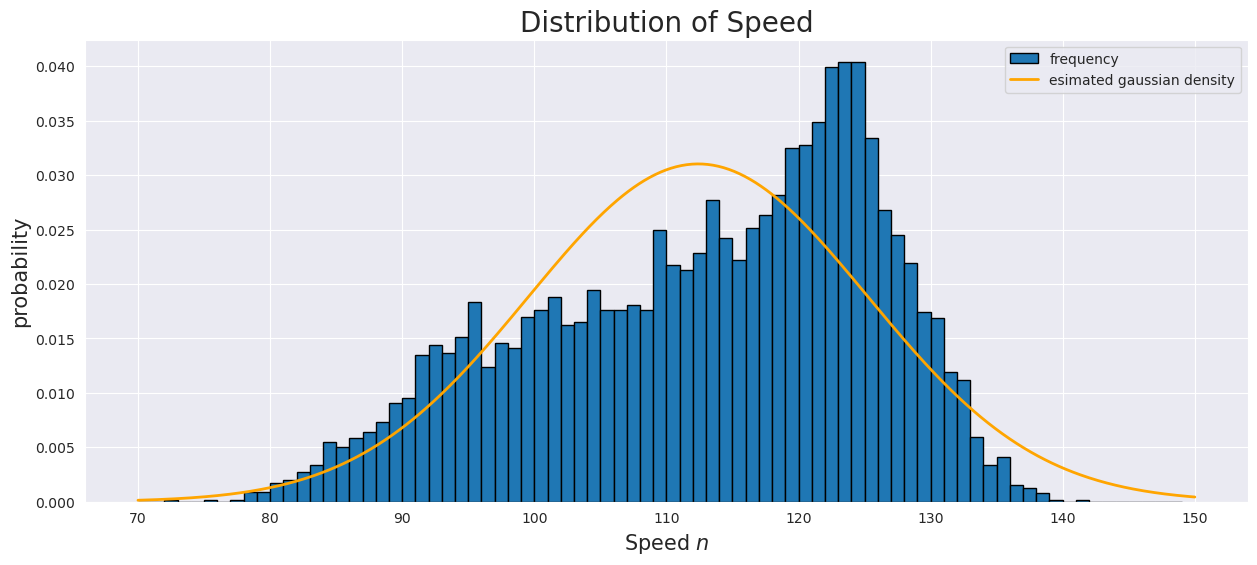

In [29]:
plt.figure(figsize=(15, 6))

plt.hist(sp, bins=range(70,150), density=True, edgecolor='black', label = "frequency")
plt.plot(x, p, 'orange', linewidth=2, label = "esimated gaussian density")
#plt.plot(x, p, 'k', linewidth=2, label = "esimated Gamma")
plt.legend()

vs.set_label("Distribution of Speed", r"Speed $n$", "probability")

vs.save("3-1-Speed")
plt.show()

In [30]:
a, b = fit_params
#nor = np.sqrt(a)*b
nor = 2*a

In [31]:
data_norm["speed_mph"] = data["speed_mph"].fillna(0)/nor
data_norm.head()

,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_break_pt_missed,p1_distance_run,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth,p1_score_diff,p2_score_diff
0,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:00,1,1,1,0,0,0,...,0,0.215059,0.281011,0.404003,0.422561,BC,NCTL,ND,0.0,0.0
1,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:00:38,1,1,2,0,0,0,...,0,0.188284,0.254272,0.202001,0.524866,B,CTL,ND,-1.0,1.0
2,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:01,1,1,3,0,0,0,...,0,0.494636,0.709982,0.808006,0.533762,B,NCTL,D,0.0,0.0
3,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:01:31,1,1,4,0,0,0,...,0,1.831873,2.710856,2.626018,0.578242,BW,CTL,D,-1.0,1.0
4,2023-wimbledon-1301,Carlos Alcaraz,Nicolas Jarry,00:02:21,1,1,5,0,0,0,...,0,0.023262,0.029141,0.202001,0.498178,W,NCTL,NaN,0.0,0.0


# Model Training

In [32]:
from utils import database as db
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [33]:
eg1 = db.select_match_norm(data_norm, "Carlos Alcaraz", "Nicolas Jarry")

In [34]:
p1_gwin_time = eg1[eg1['p1_game_win']].index
p2_gwin_time = eg1[eg1['p2_game_win']].index
p1_gwin_time

DatetimeIndex(['1900-01-01 00:05:32', '1900-01-01 00:13:26',
               '1900-01-01 00:22:19', '1900-01-01 00:30:17',
               '1900-01-01 00:36:02', '1900-01-01 00:44:29',
               '1900-01-01 01:04:21', '1900-01-01 01:19:01',
               '1900-01-01 01:28:28', '1900-01-01 01:31:59',
               '1900-01-01 01:39:56', '1900-01-01 01:47:17',
               '1900-01-01 02:07:27', '1900-01-01 02:20:27',
               '1900-01-01 02:25:59', '1900-01-01 02:28:59',
               '1900-01-01 02:36:54', '1900-01-01 02:46:29',
               '1900-01-01 03:15:53', '1900-01-01 03:26:04',
               '1900-01-01 03:30:31', '1900-01-01 03:34:53',
               '1900-01-01 03:44:23', '1900-01-01 03:48:58',
               '1900-01-01 03:56:11'],
              dtype='datetime64[ns]', name='elapsed_time', freq=None)

## Filtering with geometric kernel

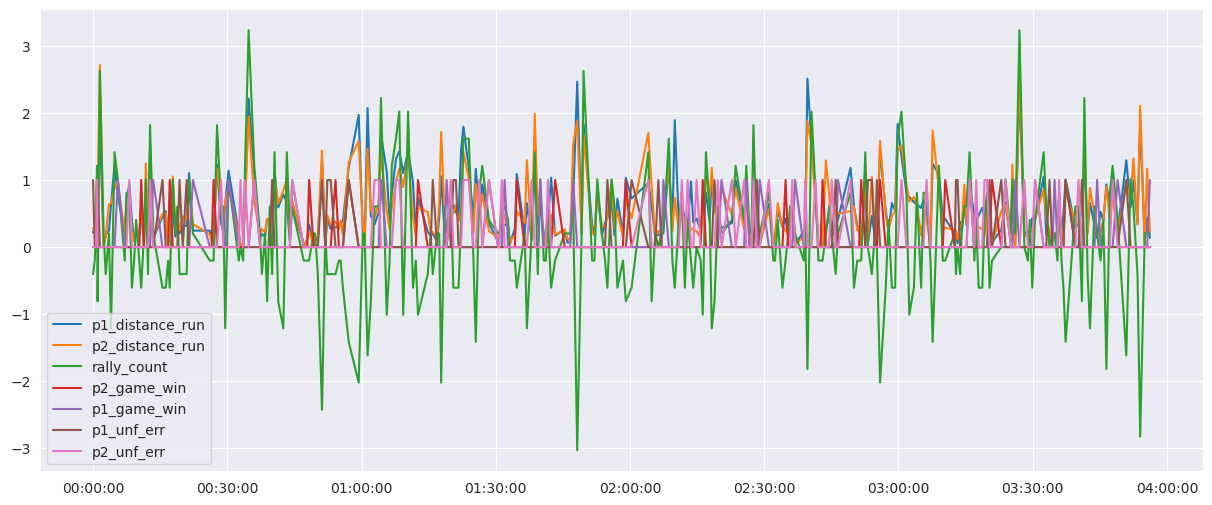

In [35]:
inputs = ["p1_distance_run","p2_distance_run", "rally_count", 'p2_game_win', 'p1_game_win', 'p1_unf_err', 'p2_unf_err']

plt.figure(figsize=(15, 6))

plt.plot(eg1[inputs], label = inputs)
vs.set_xaxis()
plt.legend()

In [36]:
for tar in inputs:
    tar_ser = eg1[tar]
    tar_ser = db.expected_P(tar_ser, 0.5, 30)
    eg1[tar] = tar_ser.values

eg1[inputs]

,p1_distance_run,p2_distance_run,rally_count,p2_game_win,p1_game_win,p1_unf_err,p2_unf_err
elapsed_time,,,,,,,
1900-01-01 00:00:00,0.215059,0.281011,-0.404003,0.000000e+00,0.000000,1.000000,0.000000
1900-01-01 00:00:22,0.247479,0.250006,-0.303002,0.000000e+00,0.000000,0.500000,0.000000
1900-01-01 00:00:38,0.217882,0.252139,-0.050500,0.000000e+00,0.000000,0.250000,0.000000
1900-01-01 00:00:53,0.630352,0.656423,0.580754,0.000000e+00,0.000000,0.125000,0.500000
1900-01-01 00:01:01,0.562494,0.683202,-0.113626,0.000000e+00,0.000000,0.562500,0.250000
...,...,...,...,...,...,...,...
1900-01-01 03:53:25,0.618653,0.671990,0.006248,1.907349e-06,0.031738,0.062517,0.015633
1900-01-01 03:54:01,1.246948,1.388404,-1.410886,9.536743e-07,0.015869,0.031259,0.007816
1900-01-01 03:55:02,0.660321,0.721246,-0.604442,4.768372e-07,0.007935,0.015629,0.003908


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


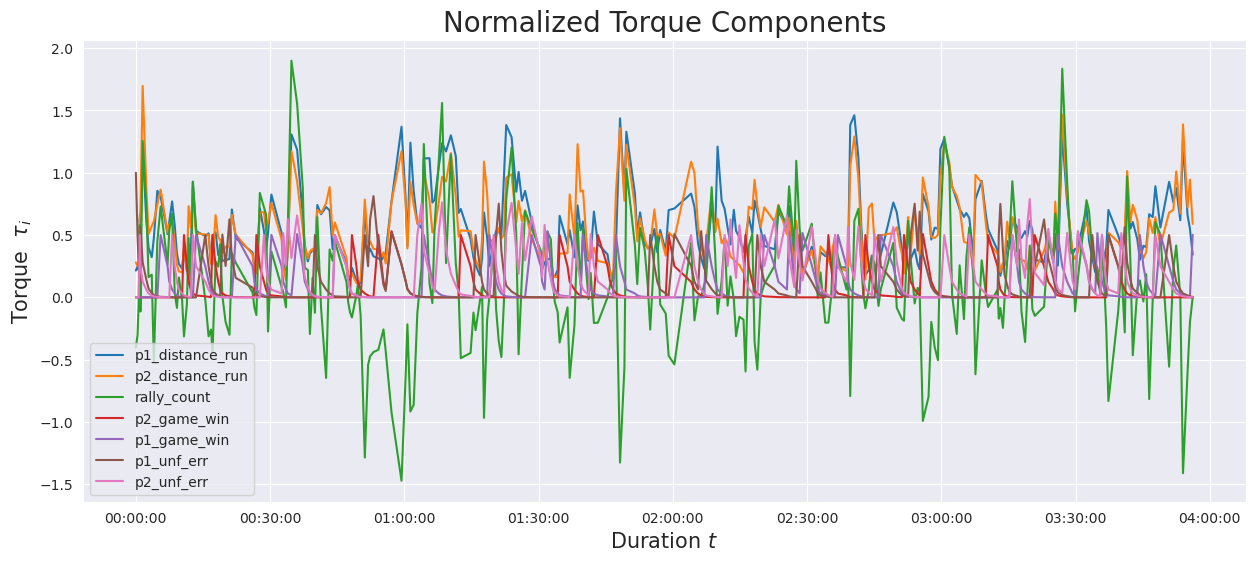

In [37]:
plt.figure(figsize=(15, 6))

plt.plot(eg1[inputs], label = inputs)
plt.legend()
vs.set_label(r"Normalized Torque Components", r"Duration $t$", r"Torque  $\tau_i$")
vs.set_xaxis()
vs.save("3-2-NormTorComps")

## Calculate the Turque

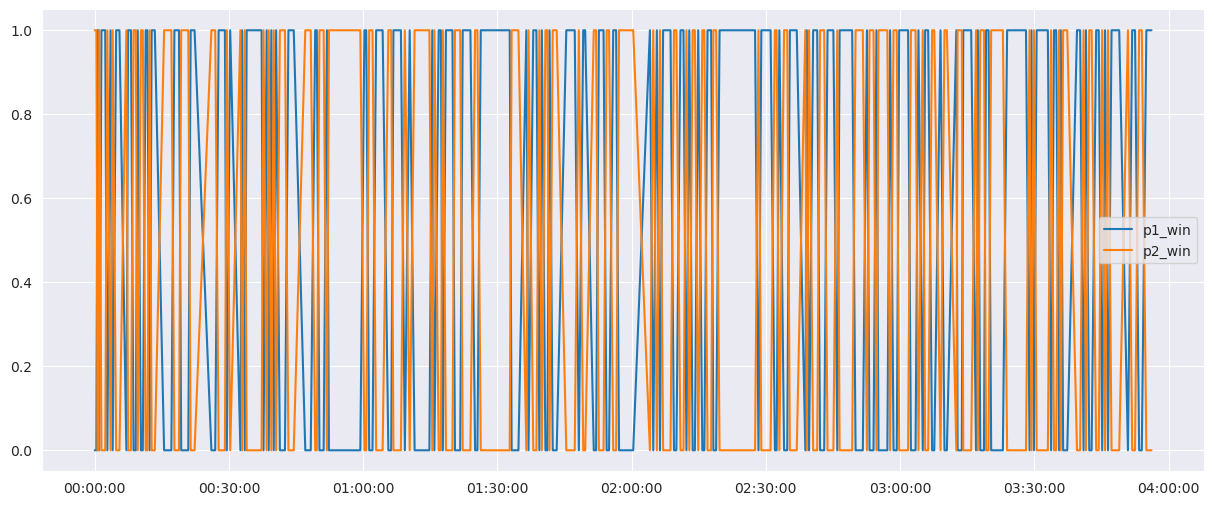

In [38]:
wins = ['p1_win', 'p2_win']

plt.figure(figsize=(15, 6))

plt.plot(eg1[wins], label = wins)
vs.set_xaxis()
plt.legend()

In [39]:
for tar in wins:
    tar_ser = eg1[tar]
    tar_ser = db.expected_P(tar_ser, 0.2, 30)
    eg1[tar] = tar_ser.values

eg1[wins]

,p1_win,p2_win
elapsed_time,,
1900-01-01 00:00:00,0.000000,1.000000
1900-01-01 00:00:22,0.000000,1.000000
1900-01-01 00:00:38,0.200000,0.800000
1900-01-01 00:00:53,0.360000,0.640000
1900-01-01 00:01:01,0.288000,0.712000
...,...,...
1900-01-01 03:53:25,0.584468,0.415532
1900-01-01 03:54:01,0.468812,0.531188
1900-01-01 03:55:02,0.575050,0.424950


In [40]:
I1 = players["Inertia"]["Carlos Alcaraz"]
I2 = players["Inertia"]["Nicolas Jarry"]

In [41]:
w1, w2 = db.get_velocity(eg1[wins[0]], I1, I2)
L1, L2 = I1*w1, I2*w2
DL1, DL2 = L1.diff().fillna(0), L2.diff().fillna(0)
Dt = DL1.index.diff().fillna(pd.to_timedelta("00:01:00"))
#Dt = db.to_minute(Dt)
Dt = Dt.to_series().apply(lambda x: x.total_seconds() / 60).values

T1, T2 = DL1/Dt, DL2/Dt

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


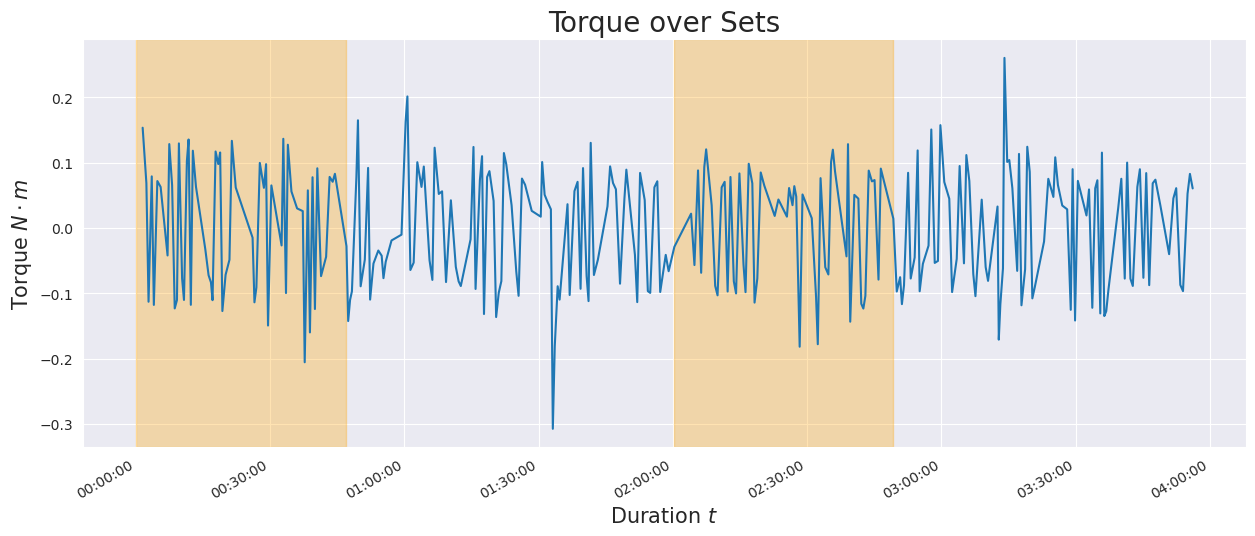

In [42]:
plt.figure(figsize=(15, 6))

T1[5:].plot()

set_range = db.get_set_range(eg1)
vs.draw_range(set_range)

vs.set_label("Torque over Sets", r"Duration $t$", r"Torque $N\cdot m$")
vs.set_xaxis()
vs.save("3-2-Torque")

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


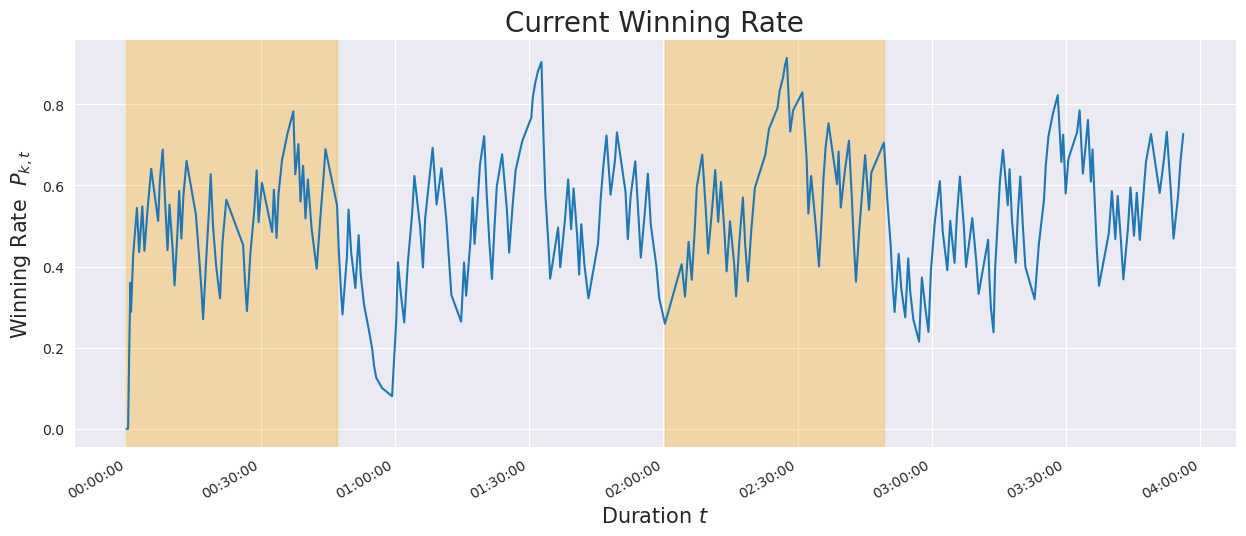

In [43]:
plt.figure(figsize=(15, 6))

eg1[wins[0]].plot()

set_range = db.get_set_range(eg1)
vs.draw_range(set_range)

vs.set_label(r"Current Winning Rate", r"Duration $t$", r"Winning Rate  $P_{k,t}$")
vs.set_xaxis()
vs.save("3-2-CurrentWinningRate")

plt.show()

## Linear Regression

$$
\hat\tau = \tau_0 + \sum_i^k\beta_i \tau_i
$$

In [44]:
import numpy as np
from sklearn.linear_model import LinearRegression

r=212 # last match

In [45]:
input1 = ['p1_win', "p1_distance_run",  'p1_game_win','p2_game_win', 'p1_score_diff', 'p1_unf_err', 'p2_unf_err', "p1_ser_sp", 'p1_ser']

x_torque = eg1[input1].values
y_torque = T1.values

x_torque

array([[0.0, 0.21505907872187768, 0.0, ..., 0.0, 0.42256149048021135,
        True],
       [0.0, 0.24747923483920076, 0.0, ..., 0.0, 0.0, False],
       [0.2, 0.21788172913010234, 0.0, ..., 0.0, 0.5248658513333152,
        True],
       ...,
       [0.5750497175817542, 0.6603209216200263, 0.007934585213661194,
        ..., 0.003908216953277588, 0.5737940239152344, True],
       [0.6600397740654034, 0.5504526429763276, 0.003967292606830597,
        ..., 0.001954108476638794, 0.569346008225969, True],
       [0.7267938792130373, 0.3427369506079602, 0.5019836463034153, ...,
        0.000977054238319397, 0.5159698199547844, True]], dtype=object)

In [46]:
model = LinearRegression(fit_intercept=False)
# Fit the model to the data
model.fit(x_torque[:r], y_torque[:r])

# Make predictions using the model
predictions1 = model.predict(x_torque)

# Print the coefficients (slope and intercept)
print("Slope (Coefficient):", model.coef_)
print("Intercept:", model.intercept_)

Slope (Coefficient): [-0.08079677 -0.02601957  0.0927175  -0.19750922 -0.04049951 -0.09775914
  0.14818113  0.23912474  0.00413544]
Intercept: 0.0


In [47]:
result = pd.DataFrame([input1,model.coef_]).T.set_index(0)
result = result.sort_values(by=1, ascending=False)

[]

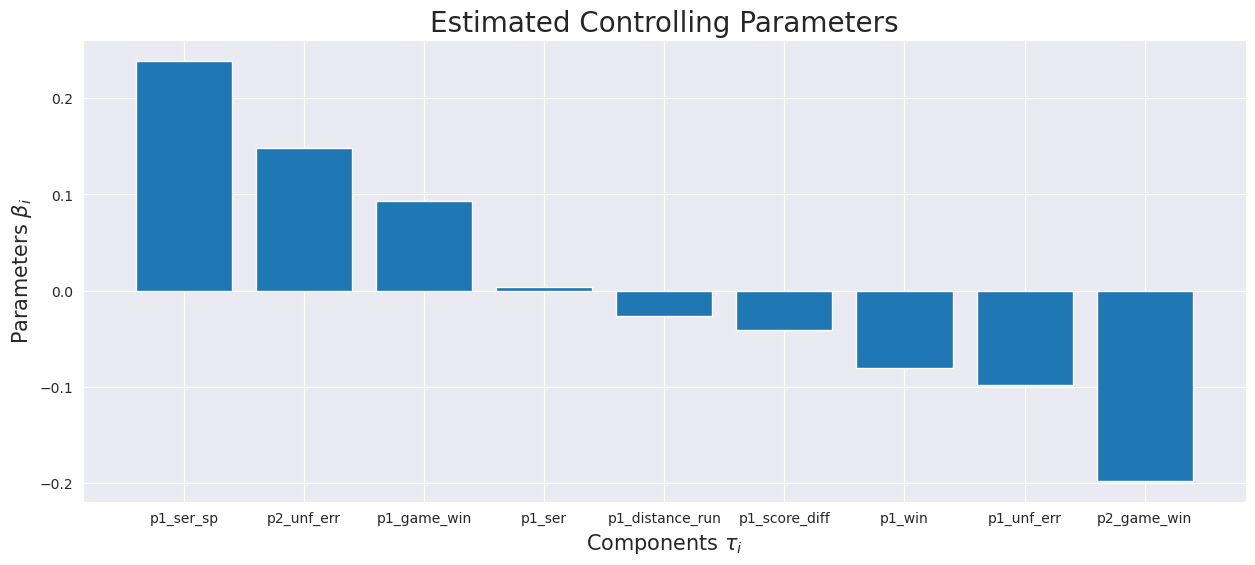

In [48]:
plt.figure(figsize=(15, 6))
plt.bar(result.index, result[1])

vs.set_label(r"Estimated Controlling Parameters", r"Components $\tau_i$", r"Parameters $\beta_i$")
vs.save("3-3-LR-Result")

plt.plot()

## Momentum Construction

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


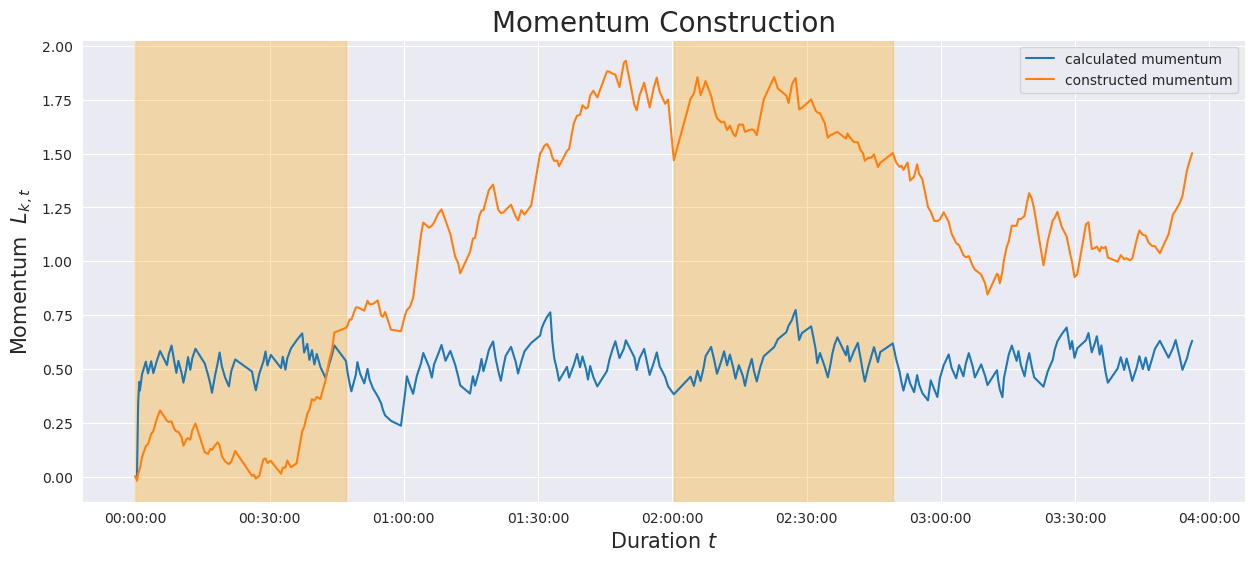

In [49]:


#eg1[tar].plot()
L1c = np.cumsum(predictions1 * Dt)

compare = pd.DataFrame(L1)
compare["constructed momentum"] = L1c

plt.figure(figsize=(15, 6))
plt.plot(compare["p1_win"], label="calculated mumentum")
plt.plot(compare["constructed momentum"], label="constructed mumentum")

vs.draw_range(set_range)
plt.legend()
vs.set_label(r"Momentum Construction", r"Duration $t$", r"Momentum  $L_{k,t}$")
vs.set_xaxis()
vs.save("3-4-ConstructedMoment")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


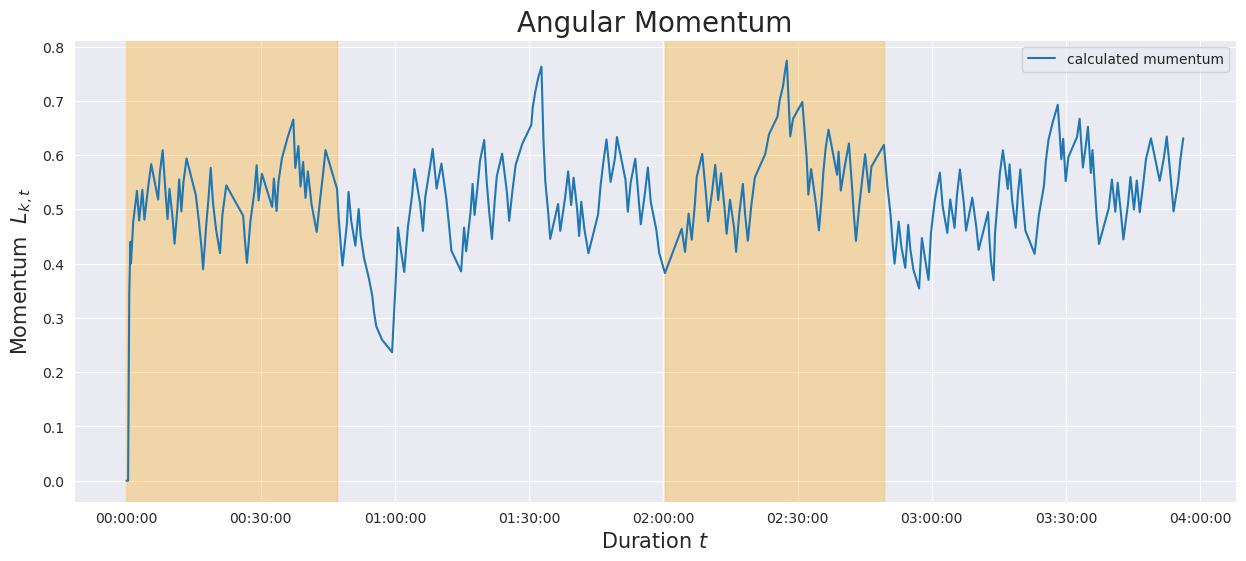

In [50]:


#eg1[tar].plot()
plt.figure(figsize=(15, 6))
plt.plot(compare["p1_win"], label="calculated mumentum")
#plt.plot(compare["constructed momentum"], label="constructed mumentum")

vs.draw_range(set_range)
plt.legend()
vs.set_label(r"Angular Momentum", r"Duration $t$", r"Momentum  $L_{k,t}$")
vs.set_xaxis()
vs.save("3-4-CalculatedMomentum")
plt.show()

## Another Player

In [51]:
input2 = ['p2_win', "p2_distance_run",  'p1_game_win','p2_game_win', 'p1_score_diff', 'p1_unf_err', 'p2_unf_err', "p2_ser_sp", 'p2_ser']

x_torque2 = eg1[input2].values
y_torque2 = T2.values

In [52]:
model2 = LinearRegression(fit_intercept=False)
# Fit the model to the data
model2.fit(x_torque2[:r], y_torque2[:r])

# Make predictions using the model
predictions2 = model2.predict(x_torque2)

[]

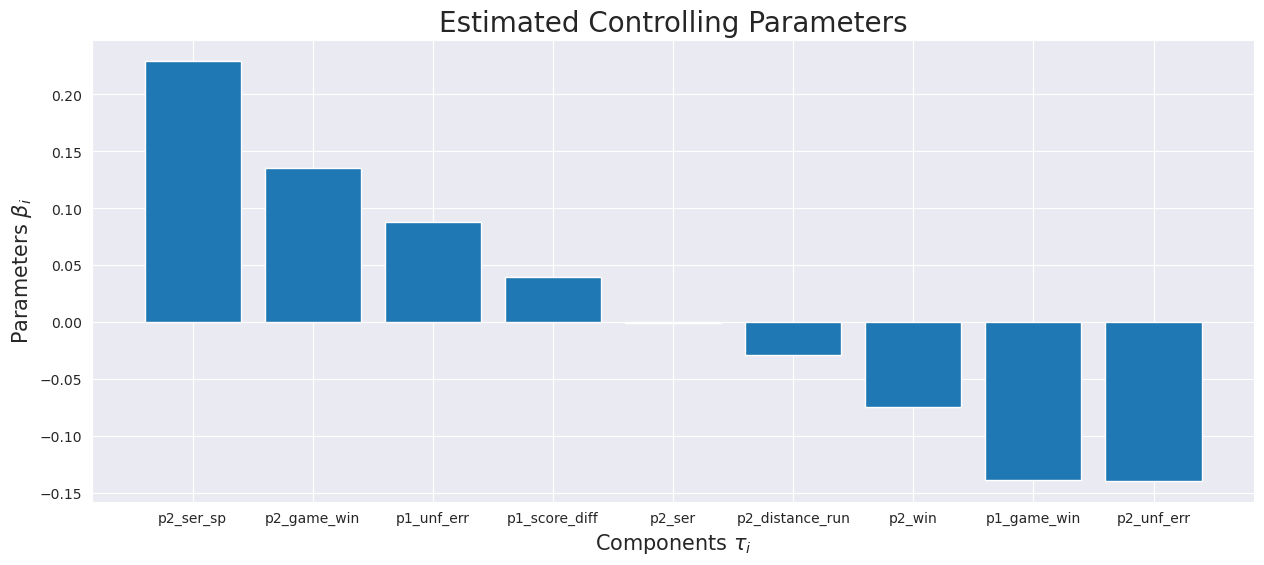

In [53]:
result2 = pd.DataFrame([input2,model2.coef_]).T.set_index(0)
result2 = result2.sort_values(by=1, ascending=False)

plt.figure(figsize=(15, 6))
plt.bar(result2.index, result2[1])

vs.set_label(r"Estimated Controlling Parameters", r"Components $\tau_i$", r"Parameters $\beta_i$")
vs.save("3-3-LR-Result2")

plt.plot()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


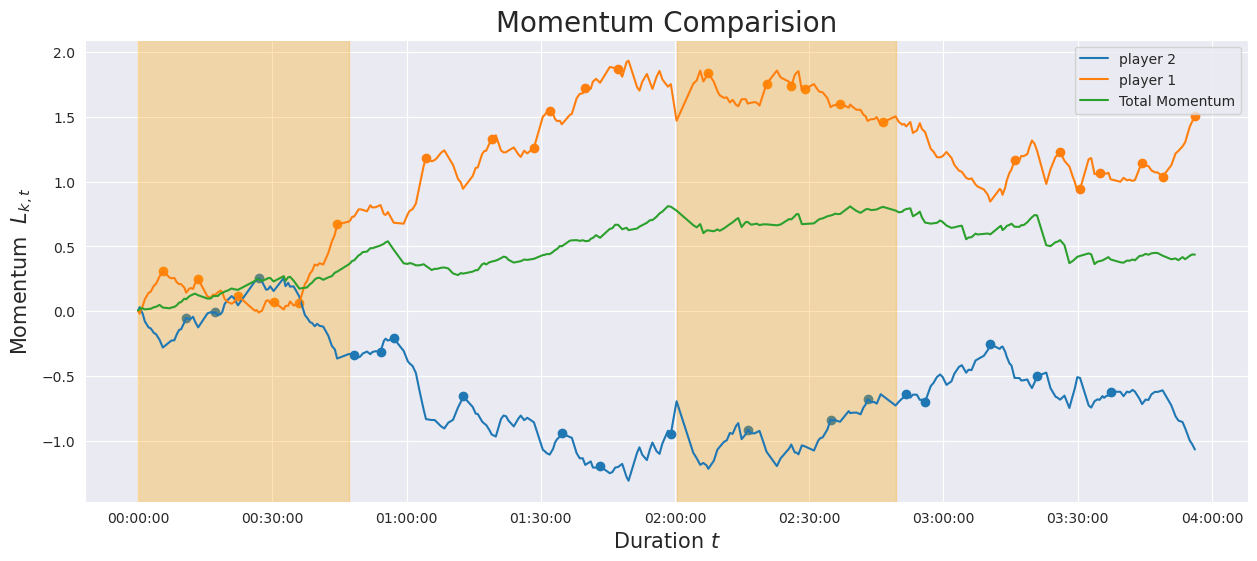

In [54]:


#eg1[tar].plot()
L1c = np.cumsum(predictions1 * Dt)
L2c = np.cumsum(predictions2 * Dt)

compare = pd.DataFrame(L1)
compare["constructed momentum"] = L1c
compare["constructed momentum2"] = L2c
compare["mean"] = L1c+L2c

plt.figure(figsize=(15, 6))
#plt.plot(compare["p1_win"], label="calculated mumentum")
plt.plot(compare["constructed momentum2"], label="player 2")
plt.plot(compare["constructed momentum"], label="player 1")
plt.plot(compare["mean"], label="Total Momentum")

plt.scatter(x=p2_gwin_time, y=compare["constructed momentum2"][p2_gwin_time])
plt.scatter(x=p1_gwin_time, y=compare["constructed momentum"][p1_gwin_time])

vs.draw_range(set_range)
plt.legend()
vs.set_label(r"Momentum Comparision", r"Duration $t$", r"Momentum  $L_{k,t}$")
vs.set_xaxis()
vs.save("4-1-PerformanceComparison")
plt.show()

In [55]:
print(set_range)

[Timestamp('1900-01-01 00:00:00'), Timestamp('1900-01-01 00:47:04'), Timestamp('1900-01-01 02:00:21'), Timestamp('1900-01-01 02:49:17'), Timestamp('1900-01-01 03:56:11')]


In [56]:
for i in range(compare.index.size):
    if compare.index[i] == set_range[3]:
        print(i)

212


In [57]:
plt.scatter?

Signature:
plt.scatter(
    x,
    y,
    s=None,
    c=None,
    marker=None,
    cmap=None,
    norm=None,
    vmin=None,
    vmax=None,
    alpha=None,
    linewidths=None,
    *,
    edgecolors=None,
    plotnonfinite=False,
    data=None,
    **kwargs,
)
Docstring:
A scatter plot of *y* vs. *x* with varying marker size and/or color.

Parameters
----------
x, y : float or array-like, shape (n, )
    The data positions.

s : float or array-like, shape (n, ), optional
    The marker size in points**2 (typographic points are 1/72 in.).
    Default is ``rcParams['lines.markersize'] ** 2``.

c : array-like or list of colors or color, optional
    The marker colors. Possible values:

    - A scalar or sequence of n numbers to be mapped to colors using
      *cmap* and *norm*.
    - A 2D array in which the rows are RGB or RGBA.
    - A sequence of colors of length n.
    - A single color format string.

    Note that *c* should not be a single numeric RGB or RGBA sequence
    because that